In [1]:
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt 
import seaborn as sns

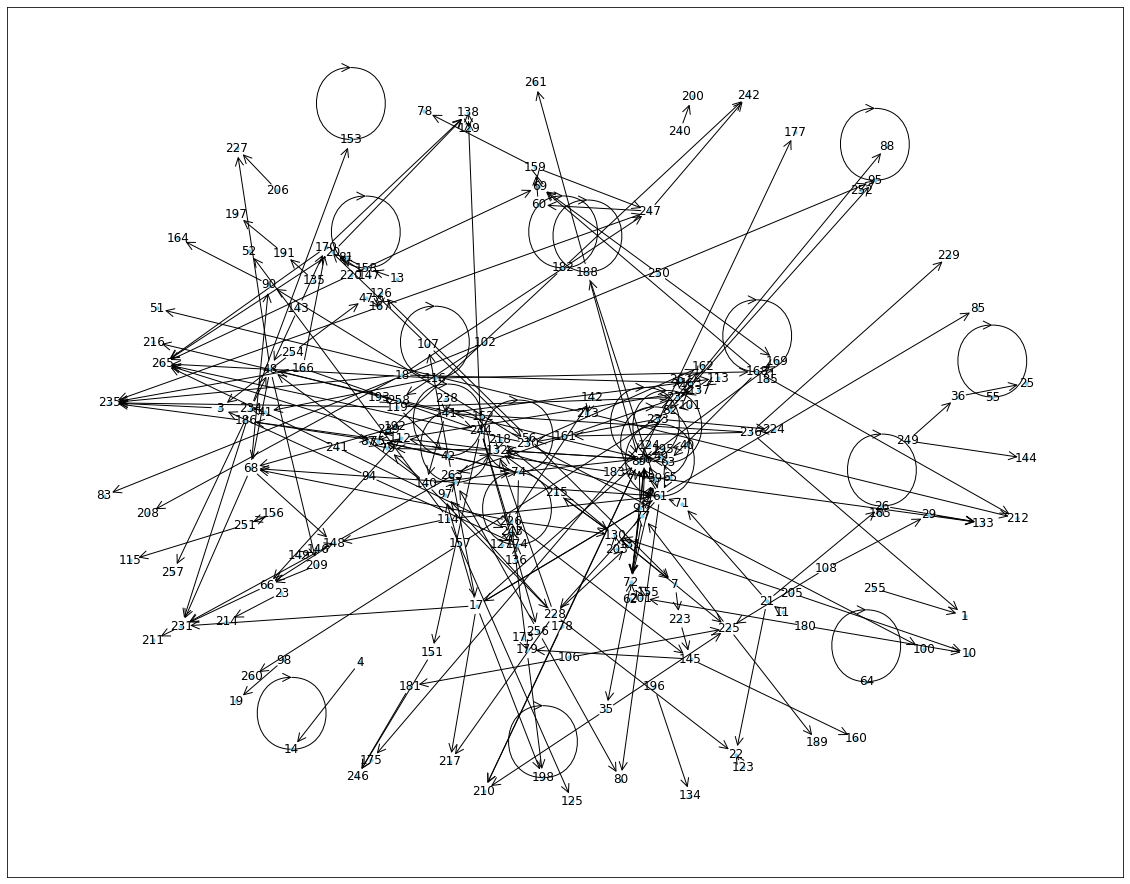

In [62]:
#Function for generating base network: 
#Here our network is a directed network where we add an edge between a Pick Up Location and Drop Off Location

def build_network(df1, df2, df3): 
    #Add print statements as needed to visualize any dataframes!
    
    #df1: original data for each month for uber rides
    #df2: taxi zone date 
    #df3: nyc weather data
    
    #Only want uber rides
    df1 = df1[df1["hvfhs_license_num"] == "HV0003"]
    
    #Formatting taxi zone df (df2)
    cols = ["LocationID", "Zone"]
    df2 = df2[cols] 
    
    #Merging the two dataframes based on location ID 
    #Only including the column, Zone

    #Merging for Pickup Zones
    merged1 = pd.merge(df1, df2, left_on='PULocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged1 = merged1.rename(columns={'Zone': 'PUZone'})
    
    #Merging for Dropoff Zones
    merged2 = pd.merge(merged1, df2, left_on='DOLocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged2 = merged2.rename(columns={'Zone': 'DOZone'})
    
    #Formating merged2 df
    cols2 = ["hvfhs_license_num", "pickup_datetime", "dropoff_datetime", "PULocationID", "DOLocationID", "trip_miles", "PUZone", "DOZone"]
    merged2 = merged2[cols2]
    
    #Formatting datetime columns
    merged2['pickup_datetime'] = pd.to_datetime(merged2['pickup_datetime'])
    merged2['dropoff_datetime'] = pd.to_datetime(merged2['dropoff_datetime'])

    merged2['pickup_datetime'] = merged2['pickup_datetime'].dt.date
    merged2['dropoff_datetime'] = merged2['dropoff_datetime'].dt.date
    
    #Formatting NYC Weather data
    cols3 = ["datetime", "temp", "precip", "preciptype"]

    #Making sure datetime column is in the correct format for merge
    df3['datetime'] = pd.to_datetime(df3['datetime'])
    df3['datetime'] = df3['datetime'].dt.date
    df3 = df3[cols3]
    
    #Merge current and nyc weather files based on datetime
    mergedf = pd.merge(merged2, df3, left_on='pickup_datetime', right_on='datetime', how='left').drop('datetime', axis=1)
    
    #Convert temperatures from C to F
    mergedf['temp'] = mergedf['temp'].astype(float)
    mergedf['temp (F)'] = mergedf['temp'] * (9 / 5) + 32 
    mergedf = mergedf.drop(columns = ['temp']) #drop temp column in C
    
    location_ids = mergedf[['PULocationID','DOLocationID']]

    #Take a sample of the data: 
    #To visualize our networks, we can use a random sample but to calculate statistics we can use raw data

    location_ids = location_ids.sample(n=300, random_state = 42)

    location_ids.columns = ['pickup', 'dropoff'] #creating an edgelist for the two columns 
    #print(location_ids)

    G = nx.from_pandas_edgelist(location_ids, source = "pickup", target = "dropoff", create_using = nx.DiGraph())

    #print(nx.info(G))


    plt.figure(figsize = (20,16))

    pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm

    # Draw nodes and edges separately to add arrows
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos)

    plt.show()
    
    
m1 = pd.read_parquet('fhvhv_tripdata_2021-01.parquet', engine='pyarrow')
taxi_zone_lookup = pd.read_csv('taxi_zone_lookup.csv')
nyc_weather = pd.read_csv('NYC_weather2021.csv')



build_network(m1, taxi_zone_lookup, nyc_weather)
    
    
#In analysis we consider the loops, where the PU Location ID = DO Location ID

In [2]:
def merged_df_analysis(df1, df2, df3):
    
    
    #Add print statements as needed to visualize any dataframes!
    
    #df1: original data for each month for uber rides
    #df2: taxi zone date 
    #df3: nyc weather data
    
    #Only want uber rides
    df1 = df1[df1["hvfhs_license_num"] == "HV0003"]
    
    #Formatting taxi zone df (df2)
    cols = ["LocationID", "Zone"]
    df2 = df2[cols] 
    
    #Merging the two dataframes based on location ID 
    #Only including the column, Zone

    #Merging for Pickup Zones
    merged1 = pd.merge(df1, df2, left_on='PULocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged1 = merged1.rename(columns={'Zone': 'PUZone'})
    
    #Merging for Dropoff Zones
    merged2 = pd.merge(merged1, df2, left_on='DOLocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged2 = merged2.rename(columns={'Zone': 'DOZone'})
    
    #Formating merged2 df
    cols2 = ["hvfhs_license_num", "pickup_datetime", "dropoff_datetime", "PULocationID", "DOLocationID", "trip_miles", "PUZone", "DOZone"]
    merged2 = merged2[cols2]
    
    #Formatting datetime columns
    merged2['pickup_datetime'] = pd.to_datetime(merged2['pickup_datetime'])
    merged2['dropoff_datetime'] = pd.to_datetime(merged2['dropoff_datetime'])

    merged2['pickup_datetime'] = merged2['pickup_datetime'].dt.date
    merged2['dropoff_datetime'] = merged2['dropoff_datetime'].dt.date
    
    #Formatting NYC Weather data
    cols3 = ["datetime", "temp", "precip", "preciptype"]

    #Making sure datetime column is in the correct format for merge
    df3['datetime'] = pd.to_datetime(df3['datetime'])
    df3['datetime'] = df3['datetime'].dt.date
    df3 = df3[cols3]
    
    #Merge current and nyc weather files based on datetime
    mergedf = pd.merge(merged2, df3, left_on='pickup_datetime', right_on='datetime', how='left').drop('datetime', axis=1)
    
    #Convert temperatures from C to F
    mergedf['temp'] = mergedf['temp'].astype(float)
    mergedf['temp (F)'] = mergedf['temp'] * (9 / 5) + 32 
    mergedf = mergedf.drop(columns = ['temp']) #drop temp column in C
    
    #Pick Up and Drop Off Analysis (Out Degree/ In Degree)
    
    #Create a dataframe with just pickup and dropoff location IDs
    
    # Count occurrences of each location in the pick-up column
    pick_up_counts = mergedf['PUZone'].value_counts().reset_index()
    pick_up_counts.columns = ['Location', 'Pick Up Count']

    # Count occurrences of each location in the drop-off column
    drop_off_counts = mergedf['DOZone'].value_counts().reset_index()
    drop_off_counts.columns = ['Location', 'Drop Off Count']
    
    #Cleaning & Aggregation 
    
    pick_up_counts = mergedf['PUZone'].value_counts().astype(int)
    
    pick_up_df = pick_up_counts.reset_index()
    pick_up_df.columns = ['Location_1', 'Pick Up Count']
    
    drop_off_counts = mergedf['DOZone'].value_counts().astype(int)
    drop_off_df = drop_off_counts.reset_index()
    drop_off_df.columns = ['Location_2', 'Drop Off Count']
    
    #Want to merge these two by Location to find locations with the greatest in and out degree
    
    merged = pd.merge(pick_up_df, drop_off_df, left_on='Location_1', right_on='Location_2', how='left').drop('Location_2', axis=1)
    
    merged = merged.rename(columns={'Location_1': 'Location'})
    
    #Merging previous two dataframes, merged and mergedf
    merged3 = pd.merge(merged, mergedf, left_on='Location', right_on='PUZone', how='left').drop('PUZone', axis=1)
    
    #Formatting dataframe
    cols4 = ["Location", "PULocationID", "Pick Up Count", "Drop Off Count", "temp (F)"]

    merged3 = merged3[cols4]
    
    #Aggregation by Location

    merged3 = merged3.groupby('Location').agg({
        'PULocationID': 'first',
        'temp (F)': 'mean',
        'Pick Up Count': 'first',
        'Drop Off Count': 'first' 
    }).reset_index()
    
    #Add a column where we calculate the In Degree/ Out Degree for each location 
    
    merged3["In Deg/ Out Deg"] = merged3["Drop Off Count"]/ merged3["Pick Up Count"]

    merged3["Difference"] = (merged3["Drop Off Count"] - merged3["Pick Up Count"]).abs()
    
    merged3 = merged3.sort_values(by = "Difference")
    
    #Deeper degree analysis outside of function 
    
    return merged3

  

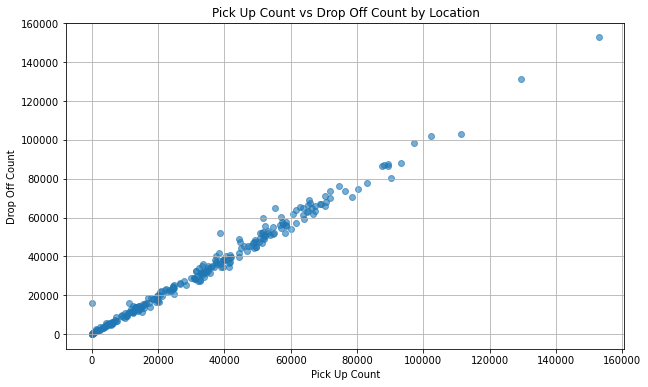

In [3]:
#Degree Analysis for Network 1 (Based on each Pick Up Location)

df = merged_df_analysis(m1, taxi_zone_lookup, nyc_weather)

#Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Pick Up Count'], df['Drop Off Count'], alpha=0.6)
plt.title('Pick Up Count vs Drop Off Count by Location')
plt.xlabel('Pick Up Count')
plt.ylabel('Drop Off Count')
plt.grid(True)
plt.show()



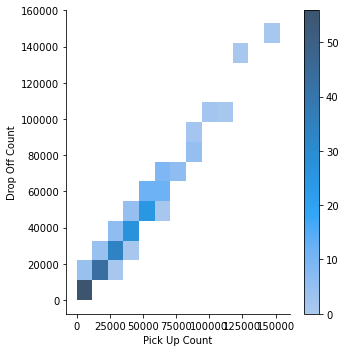

In [4]:
#Heat Plots
sns.displot(df, x="Pick Up Count", y="Drop Off Count",cbar = True) 


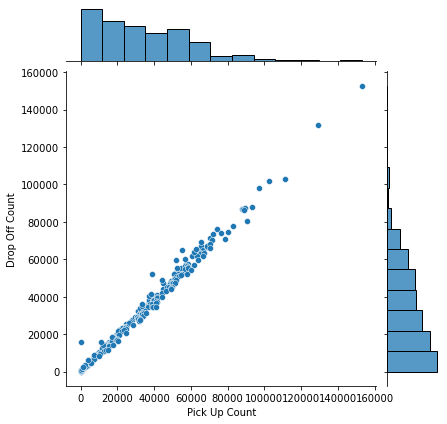

In [5]:
sns.jointplot(data=df, x="Pick Up Count", y="Drop Off Count")


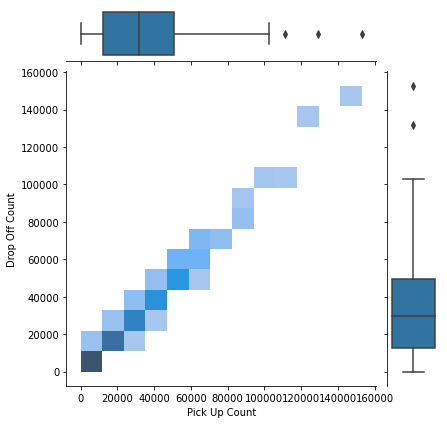

In [6]:
g = sns.JointGrid(data=df, x="Pick Up Count", y="Drop Off Count")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

In [7]:
#Can write commands such as below to perform further analysis: 

#Outliers in our data 
df[df["In Deg/ Out Deg"] > 3] 

,Location,PULocationID,temp (F),Pick Up Count,Drop Off Count,In Deg/ Out Deg,Difference
167,Newark Airport,1,40.46,1,15841.0,15841.0,15840.0


In [8]:
df[df["In Deg/ Out Deg"].isna()]


,Location,PULocationID,temp (F),Pick Up Count,Drop Off Count,In Deg/ Out Deg,Difference
194,Rikers Island,199,37.4,2,NaN,NaN,NaN


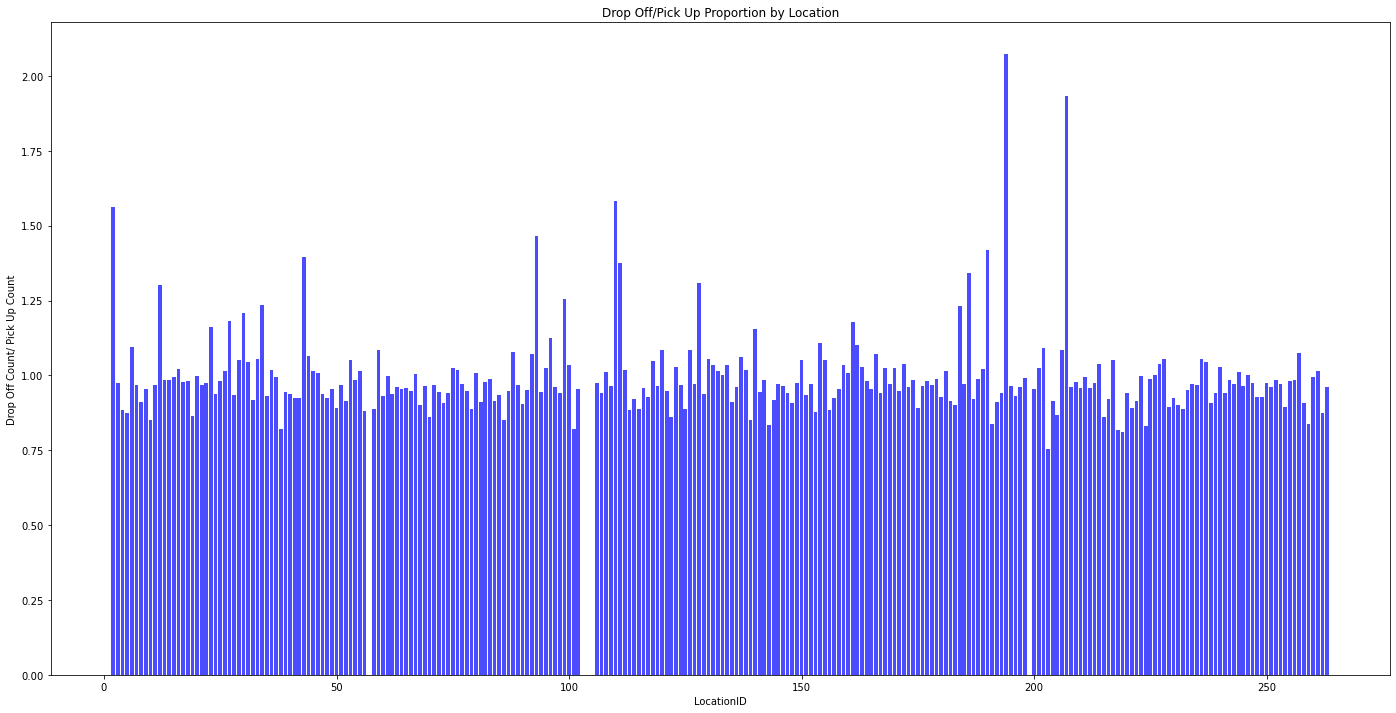

In [9]:
#Plot Location VS. In Deg/ Out Deg (Excluding LocationID 1 -- removing outliers)

merg = df[df["In Deg/ Out Deg"] < 3]
plt.figure(figsize=(24, 12))
plt.bar(merg['PULocationID'], merg['In Deg/ Out Deg'], color='blue', alpha=0.7)
plt.xlabel('LocationID')
plt.ylabel('Drop Off Count/ Pick Up Count')
plt.title('Drop Off/Pick Up Proportion by Location')
plt.show()

In [10]:
#Analysis for Network 2

#We create a second function (similar to the first) but
#We build a weighted directed network where the weight of the edge is the 
#frequency of rides from Pick Up Location to Drop Off Location 

#Add print statements as needed to visualize any dataframes!
def merged_df_analysis2(df1, df2, df3):
   
    #df1: original data for each month for uber rides
    #df2: taxi zone date 
    #df3: nyc weather data
    
    #Only want uber rides
    df1 = df1[df1["hvfhs_license_num"] == "HV0003"]
    
    #Formatting taxi zone df (df2)
    cols = ["LocationID", "Zone"]
    df2 = df2[cols] 
    
    #Merging the two dataframes based on location ID 
    #Only including the column, Zone

    #Merging for Pickup Zones
    merged1 = pd.merge(df1, df2, left_on='PULocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged1 = merged1.rename(columns={'Zone': 'PUZone'})
    
    #Merging for Dropoff Zones
    merged2 = pd.merge(merged1, df2, left_on='DOLocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged2 = merged2.rename(columns={'Zone': 'DOZone'})
    
    #Formating merged2 df
    cols2 = ["hvfhs_license_num", "pickup_datetime", "dropoff_datetime", "PULocationID", "DOLocationID", "trip_miles", "PUZone", "DOZone"]
    merged2 = merged2[cols2]
    
    #Formatting datetime columns
    merged2['pickup_datetime'] = pd.to_datetime(merged2['pickup_datetime'])
    merged2['dropoff_datetime'] = pd.to_datetime(merged2['dropoff_datetime'])

    merged2['pickup_datetime'] = merged2['pickup_datetime'].dt.date
    merged2['dropoff_datetime'] = merged2['dropoff_datetime'].dt.date
    
    #Formatting NYC Weather data
    cols3 = ["datetime", "temp", "precip", "preciptype"]

    #Making sure datetime column is in the correct format for merge
    df3['datetime'] = pd.to_datetime(df3['datetime'])
    df3['datetime'] = df3['datetime'].dt.date
    df3 = df3[cols3]
    
    #Merge current and nyc weather files based on datetime
    mergedf = pd.merge(merged2, df3, left_on='pickup_datetime', right_on='datetime', how='left').drop('datetime', axis=1)
    
    #Convert temperatures from C to F
    mergedf['temp'] = mergedf['temp'].astype(float)
    mergedf['temp (F)'] = mergedf['temp'] * (9 / 5) + 32 
    mergedf = mergedf.drop(columns = ['temp']) #drop temp column in C
    
    
    #NEW CODE 
    
    #Calculates frequency of rides from Point A to Point B only 

    frequency_of_rides = mergedf.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name='Frequency')
    
    #Calculates frequency of rides from Point B to Point A only (Denoted by Reverse Frequency)
    frequency_rev = frequency_of_rides.rename(columns={'PULocationID': 'DOLocationID', 'DOLocationID': 'PULocationID', 'Frequency': 'Reverse Frequency'})

    merged_counts = pd.merge(frequency_of_rides, frequency_rev, how='left', on=['PULocationID', 'DOLocationID'])
    merged_counts['Reverse Frequency'] = merged_counts['Reverse Frequency'].fillna(0).astype(int)  #NaNs with 0 for pairs with no reverse rides

    def sort(row):
        sorted_ids = sorted([str(row['PULocationID']), str(row['DOLocationID'])])
        return '_'.join(sorted_ids)

    merged_counts['SortedCombination'] = merged_counts.apply(sort, axis=1)

    #We drop duplicate rows based on the sorted combination column (avoid double counting in df)
    merged_counts = merged_counts.drop_duplicates('SortedCombination')

    #Remove the SC column if you don't need it anymore
    merged_counts = merged_counts.drop(columns=['SortedCombination']) 
    
    return merged_counts
    
    


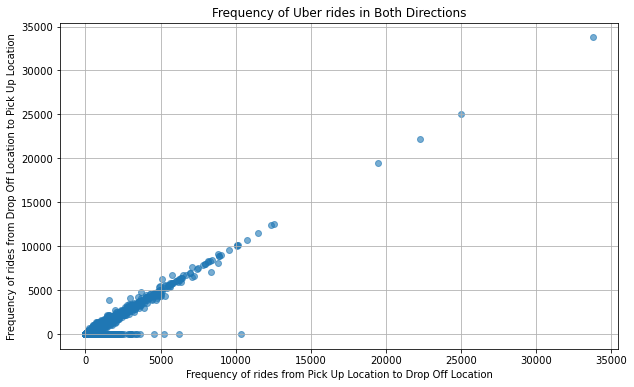

In [11]:
#Scatter Plot 

merged_counts = merged_df_analysis2(m1, taxi_zone_lookup, nyc_weather)

plt.figure(figsize=(10, 6))
plt.scatter(merged_counts['Frequency'], merged_counts['Reverse Frequency'], alpha=0.6)
plt.xlabel('Frequency of rides from Pick Up Location to Drop Off Location')
plt.ylabel('Frequency of rides from Drop Off Location to Pick Up Location')
plt.title('Frequency of Uber rides in Both Directions')
plt.grid(True)
plt.show()

In [12]:
#Correlation Coefficient 

corr_coeff = merged_counts["Frequency"].corr(merged_counts['Reverse Frequency'])
corr_coeff

0.9724716557956034

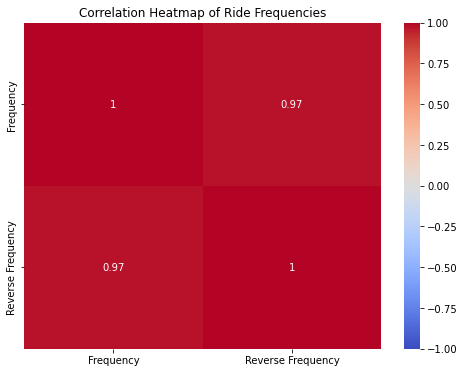

In [13]:
#Heat Plot

corr_matrix = merged_counts[['Frequency', 'Reverse Frequency']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Ride Frequencies')
plt.show()

In [ ]:
#Some tables below for frequency analysis 
#Using these commands or similar commands we can perform this analysis for any month 

In [22]:
#Many trips have the same PU and DO ID --> frequency = reverse frequency 
merged_counts[(merged_counts["PULocationID"]) == (merged_counts["DOLocationID"])]

,PULocationID,DOLocationID,Frequency,Reverse Frequency
0,1,1,1,1
17,3,3,1744,1744
228,4,4,321,321
462,5,5,230,230
557,6,6,382,382
...,...,...,...,...
54901,260,260,2655,2655
55148,261,261,254,254
55389,262,262,468,468
55639,263,263,833,833


In [23]:
#Descending Order by Reversed Frequency 
#Seeing which trips have a high reverse frequency but low frequency 
merged_counts = merged_counts.sort_values(by='Reverse Frequency', ascending=False)
merged_counts[(merged_counts["Frequency"] <= 1) & (merged_counts["Reverse Frequency"] > 1)]

,PULocationID,DOLocationID,Frequency,Reverse Frequency
6282,34,216,1,24
46165,222,224,1,23
23651,118,163,1,18
1110,9,143,1,18
19500,93,203,1,17
...,...,...,...,...
11587,59,186,1,2
11572,59,161,1,2
23038,115,203,1,2
23668,118,198,1,2


In [24]:
#Seeing which trips have a high frequency and reverse frequency 

merged_counts[(merged_counts["Frequency"] > 7000) & (merged_counts["Reverse Frequency"] > 7000) & ((merged_counts["PULocationID"]) != (merged_counts["DOLocationID"]))]

,PULocationID,DOLocationID,Frequency,Reverse Frequency
12032,61,188,8797,9123
6604,36,37,8290,8350
12068,61,225,8158,8346
7783,41,42,8138,8175
6395,35,76,8809,8115
51201,243,244,7946,7944
15468,76,77,7107,7576
2735,17,61,7467,7466
7348,39,76,8341,7061


In [25]:
#Descending Order by Frequency 
#Seeing which trips have a high frequency but low reverse frequency 

merged_counts = merged_counts.sort_values(by='Frequency', ascending=False)
merged_counts[(merged_counts["Frequency"] > 1) & (merged_counts["Reverse Frequency"] <= 1)]



,PULocationID,DOLocationID,Frequency,Reverse Frequency
36329,174,265,3429,1
33335,161,265,2923,0
48145,230,265,2805,1
9393,48,265,2591,0
48394,231,265,2401,0
...,...,...,...,...
13431,67,197,2,1
51621,245,263,2,1
540,5,225,2,1
49348,235,251,2,1


In [26]:
#Seeing which trips have a high frequency and reverse frequency 

merged_counts[(merged_counts["Frequency"] > 7000) & (merged_counts["Reverse Frequency"] > 7000) & ((merged_counts["PULocationID"]) != (merged_counts["DOLocationID"]))]

,PULocationID,DOLocationID,Frequency,Reverse Frequency
6395,35,76,8809,8115
12032,61,188,8797,9123
7348,39,76,8341,7061
6604,36,37,8290,8350
12068,61,225,8158,8346
7783,41,42,8138,8175
51201,243,244,7946,7944
2735,17,61,7467,7466
15468,76,77,7107,7576


In [27]:
#Looking for any outliers

merged_counts[(merged_counts["Frequency"] > 1) & (merged_counts["Reverse Frequency"] > 1) & ((merged_counts["PULocationID"]) != (merged_counts["DOLocationID"]))]

,PULocationID,DOLocationID,Frequency,Reverse Frequency
26772,132,265,10345,2
6395,35,76,8809,8115
12032,61,188,8797,9123
7348,39,76,8341,7061
6604,36,37,8290,8350
...,...,...,...,...
13466,67,241,2,5
13869,69,150,2,2
11754,60,157,2,4
37980,182,227,2,3


In [28]:
#Except for when PU Location = DO Location, when is frequency = reverse frequency 

merged_counts[(merged_counts["Frequency"] == merged_counts["Reverse Frequency"]) & ((merged_counts["PULocationID"]) != (merged_counts["DOLocationID"]))]

,PULocationID,DOLocationID,Frequency,Reverse Frequency
9057,47,168,1711,1711
37538,180,258,1300,1300
47863,229,231,581,581
32772,159,182,532,532
15567,76,181,459,459
...,...,...,...,...
11794,60,202,1,1
17756,86,96,1,1
32526,158,172,1,1
4783,26,127,1,1


In [14]:
#Further degree analysis utilizing second network (second function)
#Here Location, Pick Up & Drop Off Count are based on PULocationID

def merged_df_analysis3(mc,df_m):
    #the dataframe mc = mergedcounts (df generated by function 2)
    #df_m is the df generated by function 1
    
    mergedfin = pd.merge(mc, df_m, left_on='PULocationID', right_on='PULocationID', how='left')
    mergedfin["Freq/Drop Off Count"] = mergedfin["Frequency"]/ mergedfin["Drop Off Count"]
    
    mergedfin = mergedfin.sort_values(by='Freq/Drop Off Count', ascending=False)
    mergedfin = mergedfin[(mergedfin["PULocationID"]) != (mergedfin["DOLocationID"])] #Not including locations where PU = DO 
    
    return mergedfin


merged_df_analysis3(merged_counts, df)

,PULocationID,DOLocationID,Frequency,Reverse Frequency,Location,temp (F),Pick Up Count,Drop Off Count,In Deg/ Out Deg,Difference,Freq/Drop Off Count
17353,101,265,1477,14,Glen Oaks,34.942642,5813.0,4772.0,0.820919,1041.0,0.309514
27218,203,265,3374,4,Rosedale,34.868937,15213.0,11459.0,0.753237,3754.0,0.294441
5234,30,201,124,136,Broad Channel,34.514692,373.0,451.0,1.209115,78.0,0.274945
12936,73,92,2169,1741,East Flushing,34.873012,9505.0,8633.0,0.908259,872.0,0.251245
29454,259,265,6253,7,Woodlawn/Wakefield,34.854137,32572.0,27303.0,0.838235,5269.0,0.229022
...,...,...,...,...,...,...,...,...,...,...,...
10299,57,263,15,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10300,57,265,32,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26956,199,32,1,0,Rikers Island,37.400000,2.0,NaN,NaN,NaN,NaN
26957,199,140,1,0,Rikers Island,37.400000,2.0,NaN,NaN,NaN,NaN


In [47]:
#We need 12 dataframes, one for each month 

#m1 = pd.read_parquet('fhvhv_tripdata_2021-01.parquet', engine='pyarrow')
#df = merged_df_analysis(m1, taxi_zone_lookup, nyc_weather)
#merged_counts = merged_df_analysis2(m1, taxi_zone_lookup, nyc_weather)

jan_df = merged_df_analysis3(merged_counts, df) 

#m2 = pd.read_parquet('fhvhv_tripdata_2021-02.parquet', engine='pyarrow')
#df_m2 = merged_df_analysis(m2, taxi_zone_lookup, nyc_weather)
#merged_counts2 = merged_df_analysis2(m2, taxi_zone_lookup, nyc_weather)

#feb_df = merged_df_analysis3(merged_counts2, df_m2) 

#m3 = pd.read_parquet('fhvhv_tripdata_2021-03.parquet', engine='pyarrow')
#df_m3 = merged_df_analysis(m3, taxi_zone_lookup, nyc_weather)
#merged_counts3 = merged_df_analysis2(m3, taxi_zone_lookup, nyc_weather)

#mar_df = merged_df_analysis3(merged_counts3, df_m3) 

#m4 = pd.read_parquet('fhvhv_tripdata_2021-04.parquet', engine='pyarrow')
#df_m4 = merged_df_analysis(m4, taxi_zone_lookup, nyc_weather)
#merged_counts4 = merged_df_analysis2(m4, taxi_zone_lookup, nyc_weather)

#apr_df = merged_df_analysis3(merged_counts4, df_m4) 

#m5 = pd.read_parquet('fhvhv_tripdata_2021-05.parquet', engine='pyarrow')
#df_m5 = merged_df_analysis(m5, taxi_zone_lookup, nyc_weather)
#merged_counts5 = merged_df_analysis2(m5, taxi_zone_lookup, nyc_weather)

#may_df = merged_df_analysis3(merged_counts5, df_m5) 

m6 = pd.read_parquet('fhvhv_tripdata_2021-06.parquet', engine='pyarrow')
df_m6 = merged_df_analysis(m6, taxi_zone_lookup, nyc_weather)
merged_counts6 = merged_df_analysis2(m6, taxi_zone_lookup, nyc_weather)


june_df = merged_df_analysis3(merged_counts6, df_m6) 

#m7 = pd.read_parquet('fhvhv_tripdata_2021-07.parquet', engine='pyarrow')
#df_m7 = merged_df_analysis(m7, taxi_zone_lookup, nyc_weather)
#merged_counts7 = merged_df_analysis2(m7, taxi_zone_lookup, nyc_weather)


#july_df = merged_df_analysis3(merged_counts7, df_m7) 

#m8 = pd.read_parquet('fhvhv_tripdata_2021-08.parquet', engine='pyarrow')
#df_m8 = merged_df_analysis(m8, taxi_zone_lookup, nyc_weather)
#merged_counts8 = merged_df_analysis2(m8, taxi_zone_lookup, nyc_weather)


#aug_df = merged_df_analysis3(merged_counts8, df_m8) 

#m9 = pd.read_parquet('fhvhv_tripdata_2021-09.parquet', engine='pyarrow')
#df_m9 = merged_df_analysis(m9, taxi_zone_lookup, nyc_weather)
#merged_counts9 = merged_df_analysis2(m9, taxi_zone_lookup, nyc_weather)

#sept_df = merged_df_analysis3(merged_counts9, df_m9) 

#m10 = pd.read_parquet('fhvhv_tripdata_2021-10.parquet', engine='pyarrow')
#df_m10 = merged_df_analysis(m10, taxi_zone_lookup, nyc_weather)
#merged_counts10 = merged_df_analysis2(m10, taxi_zone_lookup, nyc_weather)

#oct_df - merged_df_analysis3(merged_counts10, df_m10) 

#m11 = pd.read_parquet('fhvhv_tripdata_2021-11.parquet', engine='pyarrow')
#df_m11 = merged_df_analysis(m11, taxi_zone_lookup, nyc_weather)
#merged_counts11 = merged_df_analysis2(m11, taxi_zone_lookup, nyc_weather)

#nov_df = merged_df_analysis3(merged_counts11, df_m11) 

#m12 = pd.read_parquet('fhvhv_tripdata_2021-12.parquet', engine='pyarrow')
#df_m12 = merged_df_analysis(m12, taxi_zone_lookup, nyc_weather)
#merged_counts12 = merged_df_analysis2(m12, taxi_zone_lookup, nyc_weather)

#dec_df = merged_df_analysis3(merged_counts12, df_m12) 




In [ ]:
june_df.head()

In [24]:
m4 = pd.read_parquet('fhvhv_tripdata_2021-04.parquet', engine='pyarrow')
df_m4 = merged_df_analysis(m4, taxi_zone_lookup, nyc_weather)
merged_counts4 = merged_df_analysis2(m4, taxi_zone_lookup, nyc_weather)

apr_df = merged_df_analysis3(merged_counts4, df_m4) 
apr_df.head()

,PULocationID,DOLocationID,Frequency,Reverse Frequency,Location,temp (F),Pick Up Count,Drop Off Count,In Deg/ Out Deg,Difference,Freq/Drop Off Count
5474,30,201,177,158,Broad Channel,53.704540,489.0,512.0,1.047035,23.0,0.345703
17915,101,265,1842,9,Glen Oaks,54.256557,7110.0,5562.0,0.782278,1548.0,0.331176
27960,203,265,4011,13,Rosedale,54.143236,17020.0,13222.0,0.776851,3798.0,0.303358
18066,105,45,2,0,Governor's Island/Ellis Island/Liberty Island,56.720000,3.0,7.0,2.333333,4.0,0.285714
30210,259,265,7937,17,Woodlawn/Wakefield,54.049035,36738.0,29284.0,0.797104,7454.0,0.271035


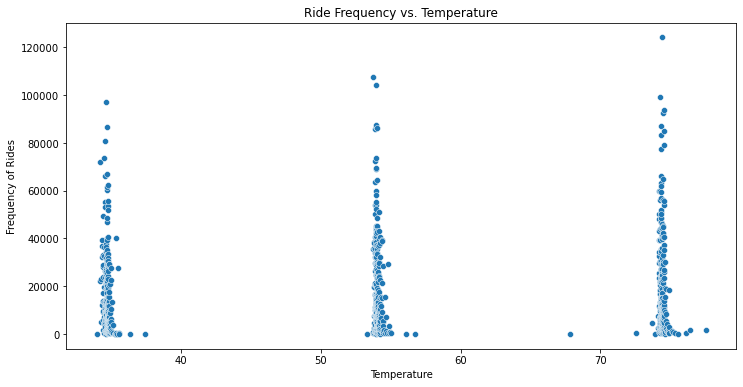

In [35]:
#Seasonal Analysis

#Frequency VS Temperature

dfs = [jan_df, apr_df, june_df]  #Combine three months with separate seasons (Jan, April, June for this one)

combined_df = pd.concat(dfs) 

temp_analysis = combined_df.groupby('temp (F)')['Frequency'].sum().reset_index()

# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temp (F)', y='Frequency', data=temp_analysis)
plt.title('Ride Frequency vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency of Rides')
plt.show()


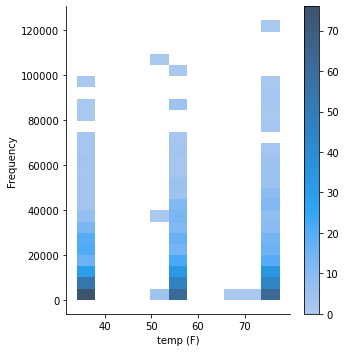

In [39]:
#Heatplot 

sns.displot(temp_analysis, x="temp (F)", y="Frequency", cbar = True)

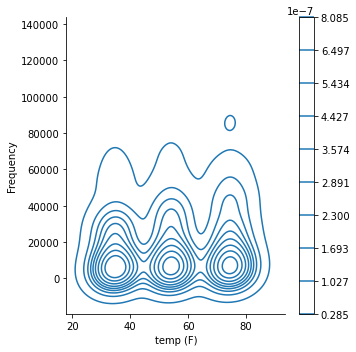

In [41]:
sns.displot(temp_analysis, x="temp (F)", y="Frequency", kind="kde", cbar = True)

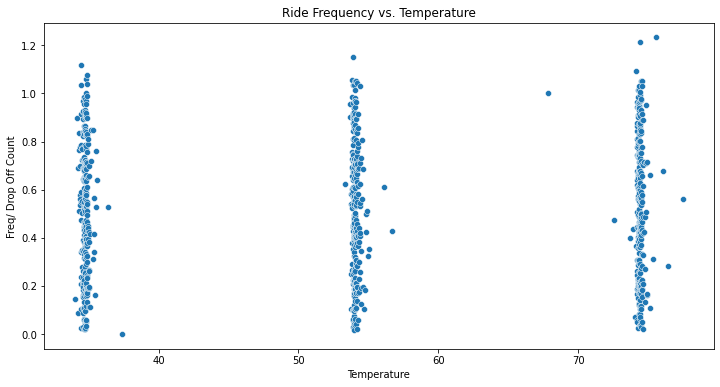

In [27]:
#Similar analysis but for Freq/ Drop Off Count VS Temperature 


dfs = [jan_df, apr_df, june_df]  #Combine two months with separate seasons 

combined_df = pd.concat(dfs) 

temp_analysis = combined_df.groupby('temp (F)')['Freq/Drop Off Count'].sum().reset_index()

# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temp (F)', y='Freq/Drop Off Count', data=temp_analysis)
plt.title('Ride Frequency vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Freq/ Drop Off Count')
plt.show()




In [58]:
#Eigenvector Centrality 

#Similar to function 2 but few more lines to help calculate eigenvector centrality 

def evc(df1, df2, df3):
   
    #df1: original data for each month for uber rides
    #df2: taxi zone date 
    #df3: nyc weather data
    
    #Only want uber rides
    df1 = df1[df1["hvfhs_license_num"] == "HV0003"]
    
    #Formatting taxi zone df (df2)
    cols = ["LocationID", "Zone"]
    df2 = df2[cols] 
    
    #Merging the two dataframes based on location ID 
    #Only including the column, Zone

    #Merging for Pickup Zones
    merged1 = pd.merge(df1, df2, left_on='PULocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged1 = merged1.rename(columns={'Zone': 'PUZone'})
    
    #Merging for Dropoff Zones
    merged2 = pd.merge(merged1, df2, left_on='DOLocationID', right_on='LocationID', how='left').drop('LocationID', axis=1)
    merged2 = merged2.rename(columns={'Zone': 'DOZone'})
    
    #Formating merged2 df
    cols2 = ["hvfhs_license_num", "pickup_datetime", "dropoff_datetime", "PULocationID", "DOLocationID", "trip_miles", "PUZone", "DOZone"]
    merged2 = merged2[cols2]
    
    #Formatting datetime columns
    merged2['pickup_datetime'] = pd.to_datetime(merged2['pickup_datetime'])
    merged2['dropoff_datetime'] = pd.to_datetime(merged2['dropoff_datetime'])

    merged2['pickup_datetime'] = merged2['pickup_datetime'].dt.date
    merged2['dropoff_datetime'] = merged2['dropoff_datetime'].dt.date
    
    #Formatting NYC Weather data
    cols3 = ["datetime", "temp", "precip", "preciptype"]

    #Making sure datetime column is in the correct format for merge
    df3['datetime'] = pd.to_datetime(df3['datetime'])
    df3['datetime'] = df3['datetime'].dt.date
    df3 = df3[cols3]
    
    #Merge current and nyc weather files based on datetime
    mergedf = pd.merge(merged2, df3, left_on='pickup_datetime', right_on='datetime', how='left').drop('datetime', axis=1)
    
    #Convert temperatures from C to F
    mergedf['temp'] = mergedf['temp'].astype(float)
    mergedf['temp (F)'] = mergedf['temp'] * (9 / 5) + 32 
    mergedf = mergedf.drop(columns = ['temp']) #drop temp column in C
    
    
    #NEW CODE 
    
    frequency_of_rides = mergedf.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name='Frequency')
    frequency_of_rides.columns = ['PULocationID', 'DOLocationID', 'Frequency'] #creating an edgelist for the two columns 
    
    return frequency_of_rides

    
    



In [59]:
#Calculate Eigenvector Centrality 

evc_analysis = evc(m1, taxi_zone_lookup, nyc_weather)

G = nx.from_pandas_edgelist(
    evc_analysis,
    source='PULocationID',
    target='DOLocationID',
    edge_attr='Frequency',
    create_using=nx.DiGraph()
)
evc = nx.eigenvector_centrality_numpy(G, weight='Frequency')

for node, centrality in evc.items():
    print(f"Node {node}: {centrality}")
    
#Nodes with a high eigenvector centrality --> node is connected to nodes that have a high in degree




Node 1: 0.009460127581484514
Node 2: 2.8540425145270816e-05
Node 35: 0.22837453614543518
Node 36: 0.11892838376704505
Node 37: 0.2017060949143441
Node 113: 0.02104140225548734
Node 122: 0.005260476608263464
Node 130: 0.03269907432915162
Node 151: 0.014520873684874026
Node 180: 0.016366233968020224
Node 181: 0.09985853925333811
Node 188: 0.21935874867367908
Node 194: 0.0016417479616670034
Node 216: 0.04079637248609891
Node 228: 0.05212064212945111
Node 258: 0.035607634225942986
Node 265: 0.12332594151889822
Node 3: 0.006084134429566232
Node 4: 0.017783027262789682
Node 7: 0.041194015224293445
Node 9: 0.0018600674826942383
Node 10: 0.021823220149670863
Node 11: 0.006669719276063978
Node 13: 0.014541034445495371
Node 14: 0.035069687181316214
Node 15: 0.001420368949777447
Node 16: 0.0033525153935609502
Node 17: 0.18731355319396267
Node 18: 0.020189970365946216
Node 19: 0.0018504436580189462
Node 20: 0.01042606422008325
Node 21: 0.0163069413693108
Node 22: 0.022988498810200295
Node 24: 0.00

In [60]:
evc_analysis

,PULocationID,DOLocationID,Frequency
0,1,1,1
1,2,35,1
2,2,36,1
3,2,37,1
4,2,113,1
...,...,...,...
55729,265,250,1
55730,265,254,11
55731,265,259,7
55732,265,263,1


In [53]:
#Sanity Check 

#Node 37 has a high EVC 

evc_analysis = evc_analysis[(evc_analysis["PULocationID"] == 37)]
total_rides = evc_analysis["Frequency"].sum()

print(total_rides)

#out of these 102434 rides there must be 1-2 drop off locations connecting specifically to PUID 37
evc_analysis = evc_analysis.sort_values(by = "Frequency", ascending=False)
evc_analysis

#Some of the nodes that have a high eigenvector centrality --> due to the fact that
#there is a high frequency with nodes that have the same PU and DO Location ID

102434


,PULocationID,DOLocationID,Frequency
6853,37,37,10099
6852,37,36,8350
7035,37,225,6277
6877,37,61,4926
6833,37,17,4876
...,...,...,...
6822,37,5,1
6819,37,2,1
6875,37,59,1
6825,37,8,1


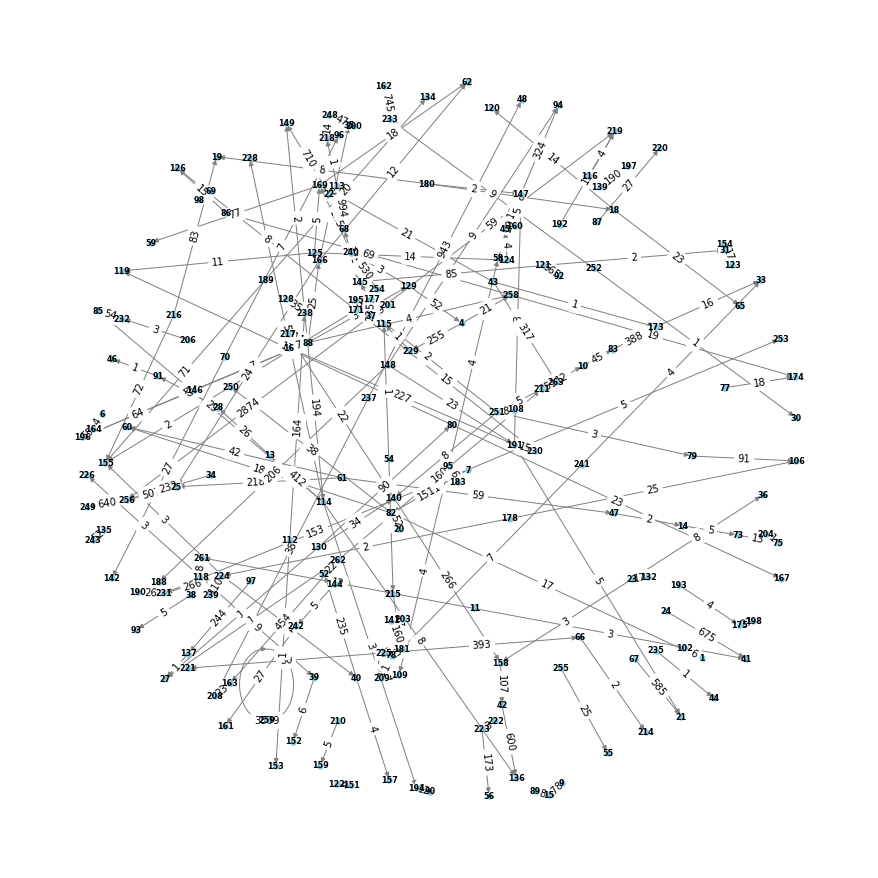

In [61]:
#Since the network is 55,734 rows we take a sample
#Building a weighted directed network where the weight of the edge is the 
#frequency of rides from Pick Up Location to Drop Off Location 

evc_analysis = evc_analysis.sample(n=200, random_state = 42)

evc_analysis.columns = ['PULocationID', 'DOLocationID', 'Frequency'] #creating an edgelist for the two columns 


G = nx.from_pandas_edgelist(
    evc_analysis,
    source='PULocationID',
    target='DOLocationID',
    edge_attr='Frequency',
    create_using=nx.DiGraph()
)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)  # k parameter affects the layout
edges = G.edges(data=True)
weights = [edge[2]['Frequency'] for edge in edges]

nx.draw(G, pos, with_labels=True, node_size=30, node_color="skyblue", font_size=8, font_weight="bold", arrows=True, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['Frequency'] for u, v, d in edges})

plt.show()
